In [5]:
import pickle 
import pandas as pd
import xgboost as xgb
import random
import numpy as np
import os, sys
import umap
import umap.plot


from sklearn.impute import SimpleImputer
from sklearn import preprocessing, model_selection
from sklearn import metrics

module_path = os.path.abspath(os.path.join('../CATENets/'))
if module_path not in sys.path:
    sys.path.append(module_path)

import catenets.models.torch.pseudo_outcome_nets as cate_models_masks


def normalize_data(x_train):
    
    x_normalized_train = (x_train - np.min(x_train, axis=0)) / (np.max(x_train, axis=0) - np.min(x_train, axis=0))

    return x_normalized_train

## Responder cohort analysis

In [12]:
fluid_cohort = pd.read_pickle("../data/trauma_responder.pkl")


all_year = pd.read_csv("../data/all_year.csv", index_col=0)

fluid_cohort = pd.merge(fluid_cohort,all_year[['registryid','iss']],on='registryid', how='left')
fluid_cohort["iss"] = pd.to_numeric(fluid_cohort["iss"], errors='coerce')

#
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]


x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                            "COV",
                                                            "TT",
                                                            "scenegcsmotor",
                                                            "scenegcseye",
                                                            "scenegcsverbal",
                                                            "edgcsmotor",
                                                            "edgcseye",
                                                            "edgcsverbal",
                                                            "outcome",
                                                            "sex_F",
                                                            "traumatype_P",
                                                            "traumatype_other"
                                                            ])]

# x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
#                                                             "COV",
#                                                             "TT", 
#                                                             "scenegcsmotor",
#                                                             "scenegcseye",
#                                                             "scenegcsverbal",
#                                                             "edgcsmotor",
#                                                             "edgcseye",
#                                                             "edgcsverbal",
#                                                             "outcome"])]

### normalize x_train 
#x = x_train.values 

n, feature_size = x.shape
names = x.drop(["treated"], axis=1).columns
treatment_index = x.columns.get_loc("treated")
iss_index = x.columns.get_loc("iss")
sex_index = x.columns.get_loc("sex_M")

var_index = [i for i in range(feature_size) if i != treatment_index and i != iss_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             fluid_cohort["outcome"], 
                                             test_size=0.2, 
                                             random_state=10,
                                             stratify=fluid_cohort["treated"]
                                    )

w_train = x_train[:, treatment_index]
w_test =  x_test[:, treatment_index]


iss_train = x_train[:, iss_index]
iss_test =  x_test[:, iss_index]

x_train = x_train[:,var_index]
x_test = x_test[:, var_index]

/tmp/ipykernel_23622/1964498440.py:4: DtypeWarning: Columns (9,16,45,57,58,59,60,61,62,63,64,71,84) have mixed types. Specify dtype option on import or set low_memory=False.
  all_year = pd.read_csv("../data/all_year.csv", index_col=0)


In [16]:
results_train = pickle.load(open("../results/responder/result_train_responder_xlearner.pkl", "rb"))
results_test = pickle.load(open("../results/responder/result_test_responder_xlearner.pkl", "rb"))

results_train = results_train.reshape(5, -1)
results_test = results_test.reshape(5, -1)

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)

threshold = np.mean(estimated_ate_train)

gender = x.columns.get_loc("sex_M")
cause_MV = x.columns.get_loc("causecode_MV")
cause_GUN = x.columns.get_loc("causecode_GUN")
scenegcs = x.columns.get_loc("scenegcs")
trauma = x.columns.get_loc("traumatype_B")
scenefirstbloodpressure = x.columns.get_loc("scenefirstbloodpressure")


lac  = x.columns.get_loc("LAC")
inr  = x.columns.get_loc("INR")
hgb  = x.columns.get_loc("HGB")
ph = x.columns.get_loc("PH")
fio2 = x.columns.get_loc("FIO2")
na = x.columns.get_loc("NA")
temp = x.columns.get_loc("temps2")
bd = x.columns.get_loc("BD")
pulse = x.columns.get_loc("edfirstpulse")

print(np.mean(iss_test)*74+1)

y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

top_2_train = x_train[:, [trauma ,cause_MV, scenegcs, cause_GUN ]]
top_2_test = x_test[:, [trauma ,cause_MV, scenegcs, cause_GUN]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("original", np.sum(estimated_ate_test[w_test==1])/n)
print("original - iss", np.mean(iss_test[w_test==1])*74+1, np.mean(iss_test[w_test==0])*74+1)


print("shap",auroc)
print("shap - ate:", ate)
print("shap - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)

top_2_train = x_train[:, [temp, ph, bd, hgb, pulse ]]
top_2_test = x_test[:, [temp, ph, bd, hgb, pulse ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("shap- 0",auroc)
print("shap-0 - ate", ate)
print("shap-0 - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)

top_2_train = x_train[:, [ph, na, temp, gender, fio2 ]]
top_2_test = x_test[:, [ph, na, temp, gender, fio2 ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("ig",auroc)
print("ig - ate", ate)
print("ig - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


top_2_train = x_train[:, [lac, inr, hgb,scenefirstbloodpressure ]]
top_2_test = x_test[:, [lac, inr,hgb, scenefirstbloodpressure ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("clnical", auroc)
print("clinical - ate", ate)
print("clinical - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(x_train, y_true_train)

y_pred = xgb_model.predict(x_test)

ate = np.sum(estimated_ate_test[y_pred == 1])/n
auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("full feature", auroc)
print("full feature - ate", ate)
print("full - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)

random_feature = np.random.randint(x_train.shape[1], size=(4))

top_2_train = x_train[:, random_feature]
top_2_test = x_test[:, random_feature]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("random feature", auroc)
print("random feature - ate", ate)
print("random - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)

0.014403417111102866 0.01822509105776346
0.019069704216733378 0.03517305039331138
29.70394736842105
original 0.003058094507370424
original - iss 29.774647887323944 28.699999999999996
shap 0.7145713788906277
shap - ate: 0.012433164428836112
shap - iss  29.845238095238095 29.529411764705884
shap- 0 0.547209181011998
shap-0 - ate 0.0025370662854015042
shap-0 - iss  30.134831460674157 29.0952380952381
ig 0.5304294905233872
ig - ate 0.0045667647204959425
ig - iss  29.073170731707318 30.442857142857147
clnical 0.5532950791166754
clinical - ate 0.0027846100569576303
clinical - iss  30.346666666666668 29.07792207792208
full feature 0.6969222743870631
full feature - ate 0.011469007882735005
full - iss  28.721518987341774 30.76712328767123
random feature 0.6519735698139455
random feature - ate 0.006411404971018612
random - iss  29.526315789473692 29.88157894736842


shap 0.7145713788906277
shap - ate: 0.012433164428836112
shap - iss  29.845238095238095 29.529411764705884


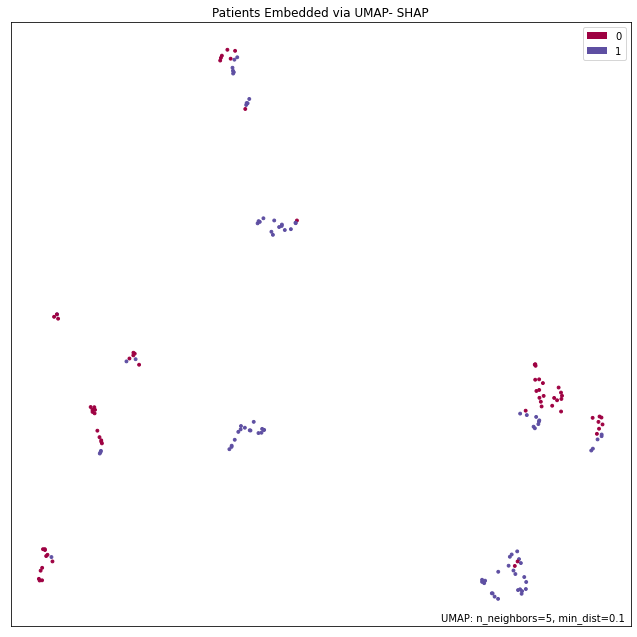

In [27]:
y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

top_2_train = x_train[:, [trauma ,cause_MV, scenegcs, cause_GUN ]]
top_2_test = x_test[:, [trauma ,cause_MV, scenegcs, cause_GUN]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("shap",auroc)
print("shap - ate:", ate)
print("shap - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


mapper = umap.UMAP(n_neighbors=5).fit(x_test)
umap.plot.points(mapper, labels=y_pred)

plt.title('Patients Embedded via UMAP- SHAP');

ig 0.5304294905233872
ig - ate 0.0045667647204959425
ig - iss  29.073170731707318 30.442857142857147


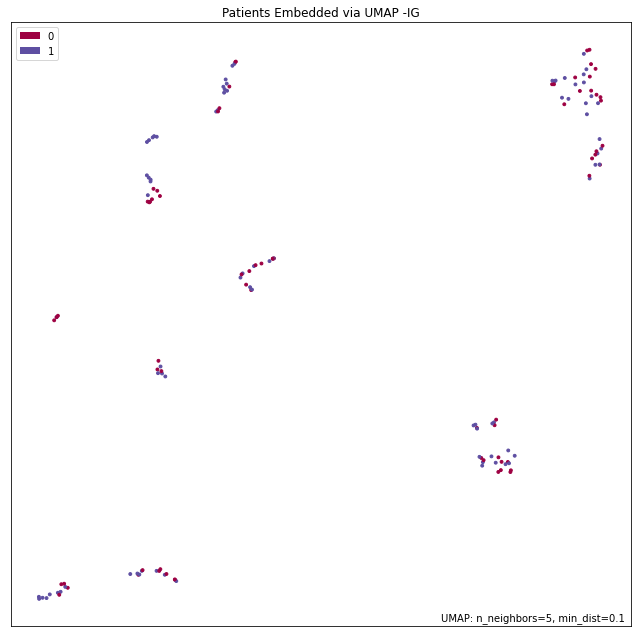

In [26]:
top_2_train = x_train[:, [ph, na, temp, gender, fio2 ]]
top_2_test = x_test[:, [ph, na, temp, gender, fio2 ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)

auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("ig",auroc)
print("ig - ate", ate)
print("ig - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)

umap.plot.points(mapper, labels=y_pred)

plt.title('Patients Embedded via UMAP -IG');

## Transfusion 

In [28]:
fluid_cohort = pd.read_pickle("../data/low_bp_survival.pkl")

all_year = pd.read_csv("../data/all_year.csv", index_col=0)

fluid_cohort = pd.merge(fluid_cohort,all_year[['registryid','iss']],on='registryid', how='left')
fluid_cohort["iss"] = pd.to_numeric(fluid_cohort["iss"], errors='coerce')

print(np.min(fluid_cohort["iss"]), np.max(fluid_cohort["iss"]))
#
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='proc')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='ethnicity')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='residencestate')))]
fluid_cohort = fluid_cohort[fluid_cohort.columns.drop(list(fluid_cohort.filter(regex='toxicologyresults')))]


x = fluid_cohort.loc[:, ~fluid_cohort.columns.isin(["registryid",
                                                    "COV",
                                                    "TT",
                                                    "scenegcsmotor",
                                                    "scenegcseye",
                                                    "scenegcsverbal",
                                                    "edgcsmotor",
                                                    "edgcseye",
                                                    "edgcsverbal",
                                                    "outcome",
                                                    "sex_F",
                                                    "traumatype_P",
                                                    "traumatype_other",
                                                ])
                    ]

n, feature_size = x.shape
names = x.drop(["treated"], axis=1).columns
treatment_index = x.columns.get_loc("treated")
iss_index = x.columns.get_loc("iss")
sex_index = x.columns.get_loc("sex_M")

var_index = [i for i in range(feature_size) if i != treatment_index and i != iss_index]

x_norm = normalize_data(x)

## impute missing value

imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(x_norm)
x_train_scaled = imp.transform(x_norm)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
                                             x_train_scaled,  
                                             fluid_cohort["outcome"], 
                                             test_size=0.2, 
                                             random_state=10,
                                             stratify=fluid_cohort["treated"]
                                    )

w_train = x_train[:, treatment_index]
w_test =  x_test[:, treatment_index]

iss_train = x_train[:, iss_index]
iss_test =  x_test[:, iss_index]

x_train = x_train[:,var_index]
x_test = x_test[:, var_index]

/tmp/ipykernel_23622/1742966114.py:3: DtypeWarning: Columns (9,16,45,57,58,59,60,61,62,63,64,71,84) have mixed types. Specify dtype option on import or set low_memory=False.
  all_year = pd.read_csv("../data/all_year.csv", index_col=0)


1.0 75.0


In [29]:
import pickle 
import xgboost as xgb
import random
from sklearn import metrics


results_train = pickle.load(open("../results/massive_trans/result_train_xlearner.pkl", "rb"))
results_test = pickle.load(open("../results/massive_trans/result_test_xlearner.pkl", "rb"))

print(results_test.shape)
results_train = results_train.reshape(5, -1)
results_test = results_test.reshape(5, -1)

print(np.mean(results_train), np.std(results_train)/np.sqrt(results_train.shape[1]))
print(np.mean(results_test), np.std(results_test)/np.sqrt(results_test.shape[1]))

estimated_ate_train = np.mean(results_train, axis=0)
estimated_ate_test = np.mean(results_test, axis=0)

print(estimated_ate_test.shape)
threshold = np.mean(estimated_ate_train)

trauma = x.columns.get_loc("traumatype_B")
gender = x.columns.get_loc("sex_M")
temp = x.columns.get_loc("temps2")
fio2 = x.columns.get_loc("FIO2")
ph = x.columns.get_loc("PH")

cause_cut = x.columns.get_loc("causecode_CUT")
cause_mv = x.columns.get_loc("causecode_MV")
edgcs = x.columns.get_loc("edgcs")
hgb  = x.columns.get_loc("HGB")
na = x.columns.get_loc("NA")

scenefirstbloodpressure = x.columns.get_loc("scenefirstbloodpressure")


lac  = x.columns.get_loc("LAC")
inr  = x.columns.get_loc("INR")

bd = x.columns.get_loc("BD")
pulse = x.columns.get_loc("edfirstpulse")


y_true_train = (estimated_ate_train > threshold)
y_true_test = (estimated_ate_test > threshold)

top_5_train = x_train[:, [gender,trauma ,cause_cut, edgcs, cause_mv ]]
top_5_test = x_test[:, [gender, trauma ,cause_cut, edgcs, cause_mv]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_5_train, y_true_train)

y_pred = xgb_model.predict(top_5_test)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("original", np.sum(estimated_ate_test[w_test==1])/n)
print("original - iss ", np.mean(iss_test[w_test==1])*74+1, np.mean(iss_test[w_test==0])*74+1)

print("shap",auroc)
print("shap - ate", ate)
print("shap - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


top_2_train = x_train[:, [temp, ph, bd, hgb, trauma ]]
top_2_test = x_test[:, [temp, ph, bd, hgb, trauma ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)
auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("shap- 0",auroc)
print("shap-0 - ate", ate)
print("shap - 0 iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


top_2_train = x_train[:, [ph, na, temp, gender, trauma ]]
top_2_test = x_test[:, [ph, na, temp, gender, trauma ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)
auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("ig",auroc)
print("ig - ate", ate)
print("ig - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


top_2_train = x_train[:, [lac, inr, hgb, trauma,scenefirstbloodpressure ]]
top_2_test = x_test[:, [lac, inr,hgb,trauma, scenefirstbloodpressure ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)
auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("clnical", auroc)
print("clinical - ate", ate)
print("clinical - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(x_train, y_true_train)

y_pred = xgb_model.predict(x_test)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("full feature", auroc)
print("full feature - ate", ate)
print("full feature - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)

random_feature = np.random.randint(x_train.shape[1], size=(4))

top_2_train = x_train[:, random_feature]
top_2_test = x_test[:, random_feature]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)

print("random feature", auroc)
print("random feature - ate", ate)
print("random - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)


(5, 201)
-0.023062477658597282 0.00899912391591147
-0.022944787911959547 0.017713969099360866
(201,)
original -0.00023330417962603807
original - iss  33.169642857142854 25.202247191011242
shap 0.6174985145573382
shap - ate 0.001437606120786344
shap - iss  25.78494623655914 32.96296296296296
shap- 0 0.5372846108140226
shap-0 - ate -0.0007112733564298764
shap - 0 iss  27.15841584158416 32.150000000000006
ig 0.5671420083184788
ig - ate -0.0009134202669615827
ig - iss  26.287128712871283 33.03000000000001
clnical 0.5775401069518717
clinical - ate 0.0008943701730632923
clinical - iss  27.126315789473683 31.896226415094343
full feature 0.6959298871063577
full feature - ate 0.004188320494861717
full feature - iss  27.128440366972477 32.619565217391305
random feature 0.5625371360665478
random feature - ate -0.0009545001877560857
random - iss  28.000000000000004 31.142857142857146


shap 0.6174985145573382
shap - ate 0.001437606120786344
shap - iss  25.78494623655914 32.96296296296296


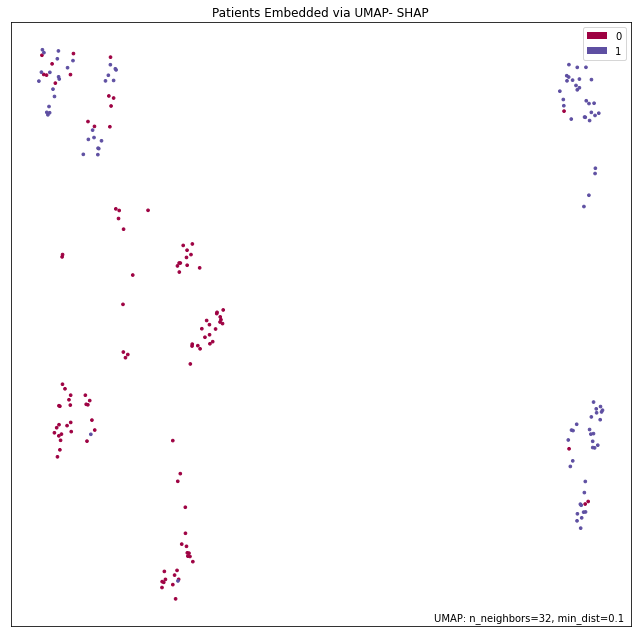

In [37]:
top_5_train = x_train[:, [gender,trauma ,cause_cut, edgcs, cause_mv ]]
top_5_test = x_test[:, [gender, trauma ,cause_cut, edgcs, cause_mv]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_5_train, y_true_train)

y_pred = xgb_model.predict(top_5_test)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

auroc = metrics.roc_auc_score(y_true_test, y_pred)
print("shap",auroc)
print("shap - ate", ate)
print("shap - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)

mapper = umap.UMAP(n_neighbors=32).fit(x_test)
umap.plot.points(mapper, labels=y_pred)

plt.title('Patients Embedded via UMAP- SHAP');

ig 0.5671420083184788
ig - ate -0.0009134202669615827
ig - iss  26.287128712871283 33.03000000000001


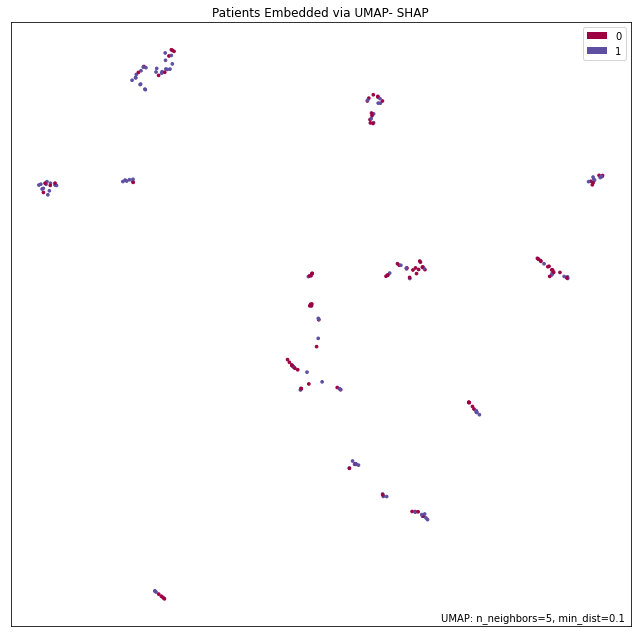

In [36]:
top_2_train = x_train[:, [ph, na, temp, gender, trauma ]]
top_2_test = x_test[:, [ph, na, temp, gender, trauma ]]

xgb_model = xgb.XGBClassifier(objective="binary:logistic")
xgb_model.fit(top_2_train, y_true_train)

y_pred = xgb_model.predict(top_2_test)
auroc = metrics.roc_auc_score(y_true_test, y_pred)
ate = np.sum(estimated_ate_test[y_pred == 1])/n

print("ig",auroc)
print("ig - ate", ate)
print("ig - iss ", np.mean(iss_test[y_pred==1])*74+1, np.mean(iss_test[y_pred==0])*74+1)

umap.plot.points(mapper, labels=y_pred)

plt.title('Patients Embedded via UMAP- SHAP');

(array([ 6., 15., 13., 17.,  8., 15.,  8.,  3.,  1.,  2.]),
 array([ 1. ,  8.4, 15.8, 23.2, 30.6, 38. , 45.4, 52.8, 60.2, 67.6, 75. ]),
 <BarContainer object of 10 artists>)

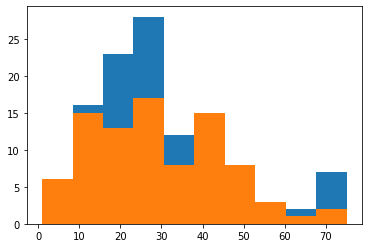

In [9]:
import matplotlib.pyplot as plt 

plt.hist(iss_test[y_pred==1]*74+1)
plt.hist(iss_test[y_pred==0]*74+1)